## 1. Project Overview and Initial Analysis of Data Characteristics

**Overview:**
- This notebook serves as the starting point for a time-series forecasting project using power generation and demand data.
- Through data loading and visualization, we will grasp the overall picture, confirm basic statistics, and diagnose "stationarity," which is a prerequisite for time-series analysis.

### 1-1. Analysis Preparation and Data Loading

- **[Note]**: It is appropriate to position this section as a "preparation" phase, encompassing everything from library import and data loading to initial data verification.

#### 1-1-1. Importing Libraries

In [1]:
# Required libraries
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.tsa.stattools import adfuller, kpss
from pmdarima.arima import nsdiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from src.data_utils import load_timeseries_data

import warnings
# Hide warnings
warnings.filterwarnings("ignore")

# Japanese font settings (for garbled text prevention) windows or mac
plt.rcParams['font.family'] = 'Meiryo' # For Windows
# plt.rcParams['font.family'] = 'Hiragino Sans' # For Mac

#### 1-1-2. Data Loading and Initial Review

In [2]:
# load data
# Directory settings and confirmation
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR.parent / "data"
print(f"Base Directory: {BASE_DIR}")
print(f"Data Directory: {DATA_DIR}")
target_file = DATA_DIR / "e_gen_demand.csv"

df = load_timeseries_data(target_file)
df.head()

Base Directory: C:\Users\ktgc1\Desktop\Time-Series-Forecasting-of-Solar-Power-and-Electric-Demand\notebooks_en
Data Directory: C:\Users\ktgc1\Desktop\Time-Series-Forecasting-of-Solar-Power-and-Electric-Demand\data


solar_gen_mw  e_demand_mw
datetime                                      
2023-01-01 00:00:00             0        29870
2023-01-01 00:30:00             0        28640
2023-01-01 01:00:00             0        27560
2023-01-01 01:30:00             0        27240
2023-01-01 02:00:00             0        26650

In [3]:
# Check data overview
print("--- describe() ---")
print(df.describe())
print("\n--- isna().sum() ---")
print(df.isna().sum())
print("\n--- info() ---")
df.info()

--- describe() ---
       solar_gen_mw   e_demand_mw
count  39408.000000  39408.000000
mean    2886.520757  32033.423924
std     4321.278840   7016.028941
min        0.000000  18440.000000
25%        0.000000  26720.000000
50%        0.000000  31150.000000
75%     5040.000000  36420.000000
max    16740.000000  57080.000000

--- isna().sum() ---
solar_gen_mw    0
e_demand_mw     0
dtype: int64

--- info() ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39408 entries, 2023-01-01 00:00:00 to 2025-03-31 23:30:00
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   solar_gen_mw  39408 non-null  int64
 1   e_demand_mw   39408 non-null  int64
dtypes: int64(2)
memory usage: 923.6 KB


**Data Source**

##### Generation/Consumption

Source: TEPCO Power Grid  
Denki Yoho (Electricity Forecast) - Past electricity usage data  
https://www.tepco.co.jp/forecast/html/download_year-j.html#2025

| DATE     | TIME  | Actual Demand (5-min intervals) (10,000 kW) | Solar Power Generation (5-min intervals) (10,000 kW) | Solar Power Generation (Ratio to Demand) (%) |
|----------|-------|:--------------------------------:|:-------------------------------------:|:---------------------------------:|
| 2025/1/1 | 12:00 | 2454                             | 1134                                  | 46                                |
| 2025/1/1 | 12:05 | 2496                             | 1131                                  | 45                                |
| 2025/1/1 | 12:10 | 2471                             | 1125                                  | 45                                |

Values every 30 minutes are used from 5-minute interval data (without averaging). Converted to MW (megawatts).

No missing data was observed. It was confirmed that solar power generation frequently registers zero values.

### 1-2. Visualization and Overview of the Entire Dataset

#### 1-2-1. Time Series Plot of Electricity Generation and Demand

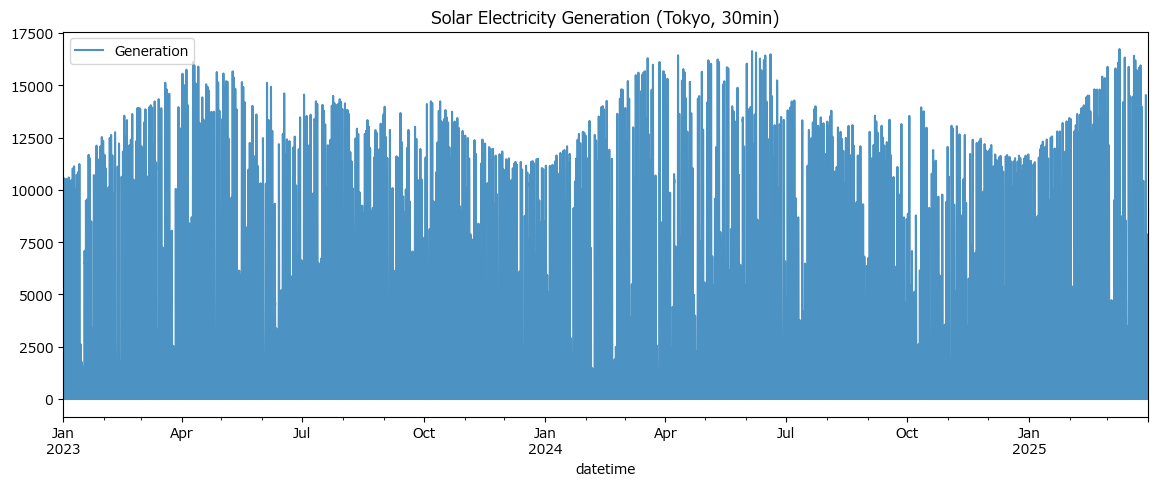

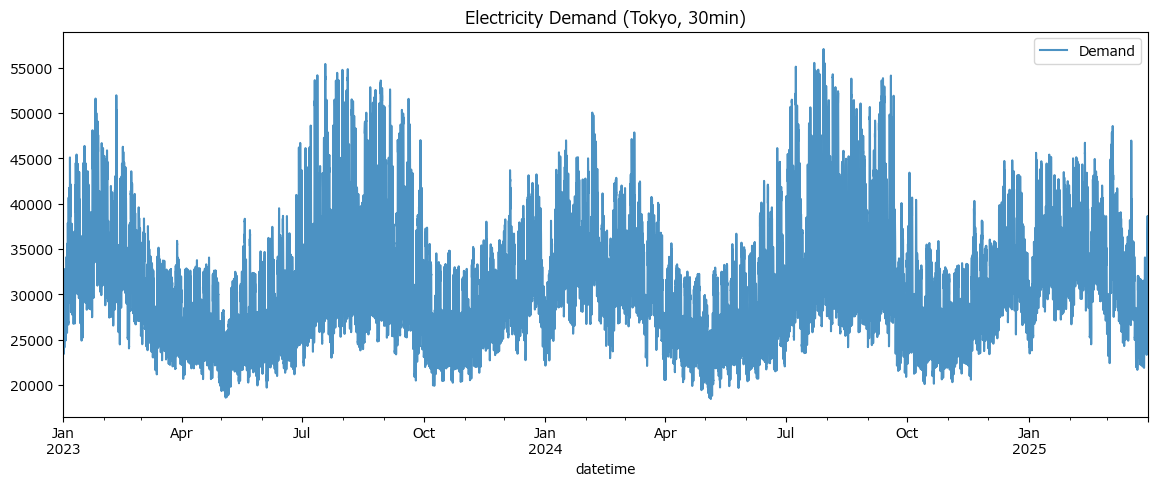

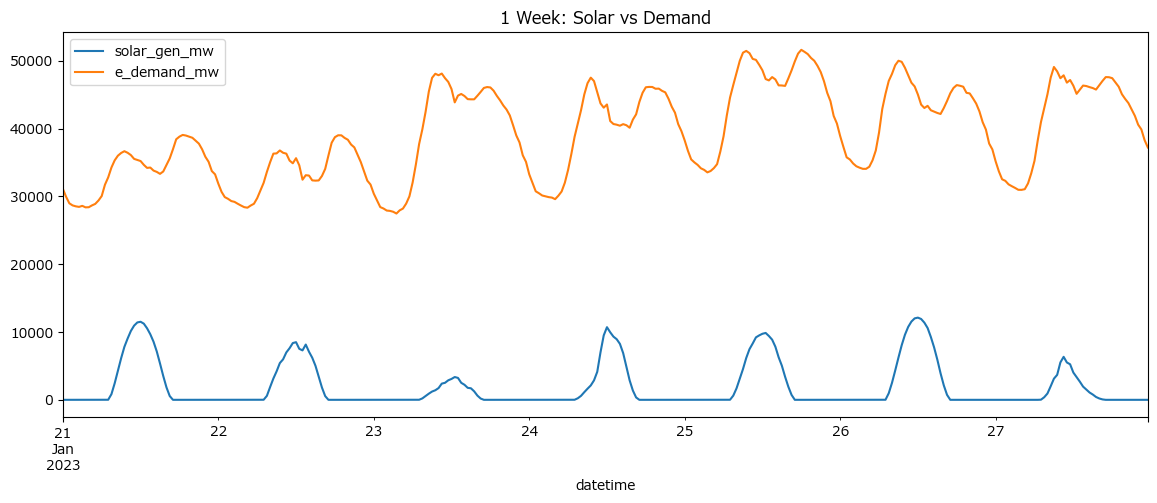

In [4]:
# Visualization
plt.figure(figsize=(14,5))
df["solar_gen_mw"].plot(label="Generation", alpha=0.8)
plt.title("Solar Electricity Generation (Tokyo, 30min)")
plt.legend()
plt.show()

plt.figure(figsize=(14,5))
df["e_demand_mw"].plot(label="Demand", alpha=0.8)
plt.title("Electricity Demand (Tokyo, 30min)")
plt.legend()
plt.show()

# 5. Short-term (1 week) trends in solar power generation and demand. *We plotted the data starting 20 days later 
# to avoid the unusual consumption patterns around January 1st (holidays/long weekends).
df[["solar_gen_mw", "e_demand_mw"]].iloc[960:960+7*48].plot(figsize=(14,5), title="1 Week: Solar vs Demand")
plt.show()

A short-term graph for the week of the 100th day (starting April 11th, Tuesday), avoiding the special New Year's period.

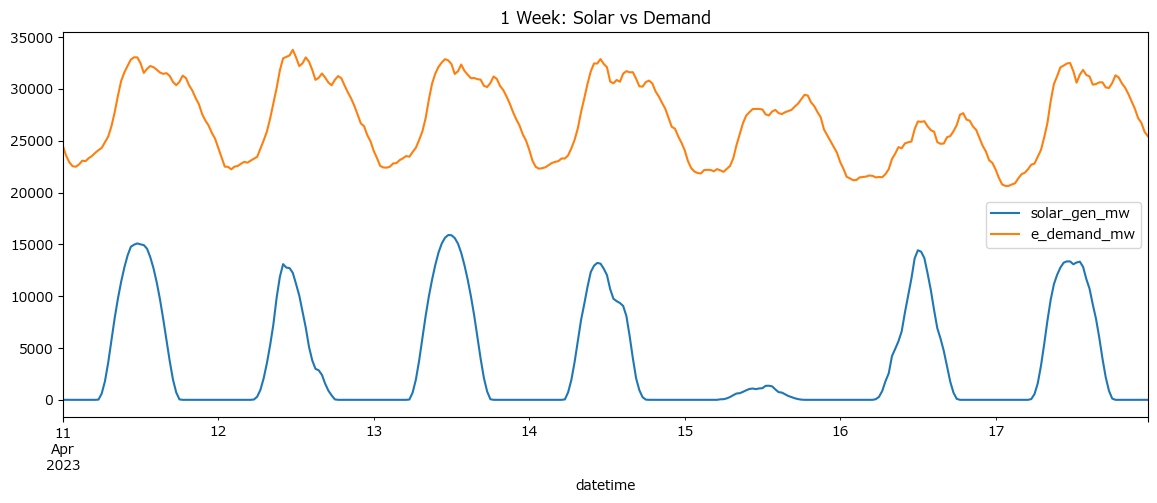

In [5]:
df[["solar_gen_mw", "e_demand_mw"]].iloc[4800:4800 + 7*48].plot(figsize=(14,5), title="1 Week: Solar vs Demand")
plt.show()

**Initial Observations on Short-Term Periodicity and Trends from the Graphs**

- Solar power generation is quite regular, dropping to zero before sunrise and after sunset. While subsequently confirmed with Plotly, peak reductions due to weather were observed.

- Electricity consumption exhibits a unique pattern from around January 1st to January 4th, attributable to the New Year's holiday period (San-ga-nichi). This was also corroborated with Plotly; subsequently, it rapidly ascends in the morning, experiences a lull from midday to afternoon (either a decrease or a plateau), and diminishes after sunset.

#### 1-2-2. Overall Data Visualization Part 2: Interactive Plotly Display

In [6]:
# Solar power generation visualization (plotly)
fig1 = px.line(
    df,
    y="solar_gen_mw",
    title="<b>Solar Power Generation Trend (Every 30 minutes)</b>",
    labels={"datetime": "Date/Time", "solar_gen_mw": "Solar Power Generation (MW)"}
)

# Update layout to add range slider and period selection buttons
fig1.update_layout(
    title_x=0.5, # Center the title
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                # Button definitions
                dict(count=7, label="1 week", step="day", stepmode="backward"),
                dict(count=1, label="1 month", step="month", stepmode="backward"),
                dict(count=3, label="3 months", step="month", stepmode="backward"),
                dict(step="all", label="All period")
            ])
        ),
        rangeslider=dict(
            visible=True  # Show range slider
        ),
        type="date"
    )
)

fig1.show()

In [7]:
# Electricity demand visualization (plotly)
fig2 = px.line(
    df,
    y="e_demand_mw",
    title="Electricity demand trend (every 30 minutes)",
    labels={"datetime": "Datetime", "e_demand_mw": "Electricity demand (MW)"}
)

# Updating layout to add range slider and period selection buttons
fig2.update_layout(
    title_x=0.5, # Center the title
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                # Button definitions
                dict(count=7, label="1 week", step="day", stepmode="backward"),
                dict(count=1, label="1 month", step="month", stepmode="backward"),
                dict(count=3, label="3 months", step="month", stepmode="backward"),
                dict(step="all", label="All period")
            ])
        ),
        rangeslider=dict(
            visible=True  # Show range slider
        ),
        type="date"
    )
)

fig2.show()

### 1-3. Time Series Data Stationarity Diagnosis

#### 1-3-1. Performing Stationarity Tests (ADF Test, KPSS Test) and Seasonal Stationarity Test (OCSB Test)
Stationarity tests are performed using ADF and KPSS, and seasonal stationarity tests using OCSB. These are performed on the original series, first difference, and seasonal first difference.

In [8]:
# =====================================================
# Test function
# =====================================================

def stationarity_tests(series, name='series', m=48, alpha=0.05):
    """Execute ADF, KPSS, and OCSB tests together"""
    print(f"\n===== {name} =====")

    # --- ADF Test ---
    adf_stat, adf_p, _, _, adf_crit, _ = adfuller(series.dropna(), autolag='AIC')
    adf_result = "Stationary" if adf_p < alpha else "Non-stationary"
    print(f"[ADF] p={adf_p:.4f} -> {adf_result}")

    # --- KPSS Test ---
    kpss_stat, kpss_p, _, kpss_crit = kpss(series.dropna(), regression='c', nlags='auto')
    kpss_result = "Non-stationary" if kpss_p < alpha else "Stationary"
    print(f"[KPSS] p={kpss_p:.4f} -> {kpss_result}")

    # --- OCSB (pmdarima) ---
    try:
        D = nsdiffs(series, m=m, test='ocsb', max_D=2)
        print(f"[OCSB] Estimated seasonal differencing D={D} (Period m={m})")
    except Exception as e:
        print(f"[OCSB] Error: {e}")

In [9]:
# =====================================================
# Stationarity Diagnosis (Original Series / After Differencing)
# =====================================================

for col, m in [('solar_gen_mw', 48), ('e_demand_mw', 336)]:
    series = df[col]
    print(f"\n===== {col.upper()} | Period m={m} =====")
    stationarity_tests(series, name=f"{col} (original)", m=m)

    # Regular Differencing
    series_diff = series.diff().dropna()
    stationarity_tests(series_diff, name=f"{col} (diff=1)", m=m)

    # Seasonal Differencing (e.g., 1 period)
    series_seas_diff = series.diff(m).dropna()
    stationarity_tests(series_seas_diff, name=f"{col} (seasonal diff m={m})", m=m)


===== SOLAR_GEN_MW | Period m=48 =====

===== solar_gen_mw (original) =====
[ADF] p=0.0000 -> Stationary
[KPSS] p=0.0497 -> Non-stationary
[OCSB] Estimated seasonal differencing D=0 (Period m=48)

===== solar_gen_mw (diff=1) =====
[ADF] p=0.0000 -> Stationary
[KPSS] p=0.1000 -> Stationary
[OCSB] Estimated seasonal differencing D=0 (Period m=48)

===== solar_gen_mw (seasonal diff m=48) =====
[ADF] p=0.0000 -> Stationary
[KPSS] p=0.1000 -> Stationary
[OCSB] Estimated seasonal differencing D=0 (Period m=48)

===== E_DEMAND_MW | Period m=336 =====

===== e_demand_mw (original) =====
[ADF] p=0.0000 -> Stationary
[KPSS] p=0.0114 -> Non-stationary
[OCSB] Estimated seasonal differencing D=0 (Period m=336)

===== e_demand_mw (diff=1) =====
[ADF] p=0.0000 -> Stationary
[KPSS] p=0.1000 -> Stationary
[OCSB] Estimated seasonal differencing D=0 (Period m=336)

===== e_demand_mw (seasonal diff m=336) =====
[ADF] p=0.0000 -> Stationary
[KPSS] p=0.1000 -> Stationary
[OCSB] Estimated seasonal differenc

#### 1-3-2. Consolidation and Analysis of Test Results

**Summary of Test Results**

===== SOLAR_GEN_MW | Period m=48 =====

===== solar_gen_mw (original) =====  
[ADF] p=0.0000 → Stationary  
[KPSS] p=0.0497 → Non-stationary  
[OCSB] Estimated Seasonal Difference D=0 (Period m=48)  

===== solar_gen_mw (diff=1) =====  
[ADF] p=0.0000 → Stationary  
[KPSS] p=0.1000 → Stationary  
[OCSB] Estimated Seasonal Difference D=0 (Period m=48)  

===== solar_gen_mw (seasonal diff m=48) =====  
[ADF] p=0.0000 → Stationary  
[KPSS] p=0.1000 → Stationary  
[OCSB] Estimated Seasonal Difference D=0 (Period m=48)  


===== E_DEMAND_MW | Period m=336 =====

===== e_demand_mw (original) =====  
[ADF] p=0.0000 → Stationary  
[KPSS] p=0.0114 → Non-stationary  
[OCSB] Estimated Seasonal Difference D=0 (Period m=336)  

===== e_demand_mw (diff=1) =====  
[ADF] p=0.0000 → Stationary  
[KPSS] p=0.1000 → Stationary  
[OCSB] Estimated Seasonal Difference D=0 (Period m=336)  

===== e_demand_mw (seasonal diff m=336) =====  
[ADF] p=0.0000 → Stationary  
[KPSS] p=0.1000 → Stationary  
[OCSB] Estimated Seasonal Difference D=0 (Period m=336)

**Analysis of Test Results and Strategy for Stationarity**

In time series tests, it is common to encounter contradictory results where the ADF test indicates "stationary" (no unit root) and the KPSS test indicates "non-stationary" (presence of trend/level instability). This is primarily due to the differing null hypotheses and sensitivities of the two tests.

1. Differences Between ADF and KPSS Tests

*   ADF Sensitivity: Primarily sensitive to the presence or absence of a unit root (random-walk-like non-stationarity). If seasonality or deterministic trends are present, it may incorrectly conclude "stationary" (power of the test decreases).
*   KPSS Sensitivity: Primarily sensitive to deviations from level-stationarity/trend-stationarity. With smooth trends or strong seasonality (low-frequency components), it tends to lean towards "non-stationary" (null hypothesis: stationarity is rejected) even with slight level/trend instability.

2. Diagnosis using OCSB Test (Seasonal Unit Root)

For time series with seasonality, this test examines seasonal non-stationarity (= presence or absence of a seasonal unit root), where the seasonal pattern itself is unstable over time. If a seasonal unit root is present, seasonal differencing ($D=1$) is required.

*   pmdarima's nsdiffs(..., test='ocsb') can directly estimate the necessary order $D$ of seasonal differencing. This eliminates the effort of interpreting results and can be directly utilized for SARIMA model configuration.

3. Conclusion for This Data

From the summary of test results, the following insights were obtained:

*   Regular Differencing (d=1): For both power generation and consumption, taking the 1st difference resulted in a stationary determination by both ADF and KPSS tests (KPSS $p=0.1000$).
*   Seasonal Differencing (D): According to the OCSB test results, the estimated seasonal difference $D=0$ for both power generation ($m=48$) and consumption ($m=336$). This suggests that seasonal differencing is not required.

### 1-4. Analysis of Autocorrelation and Implications for Model Selection

#### 1-4-1. Visualization of ACF and PACF

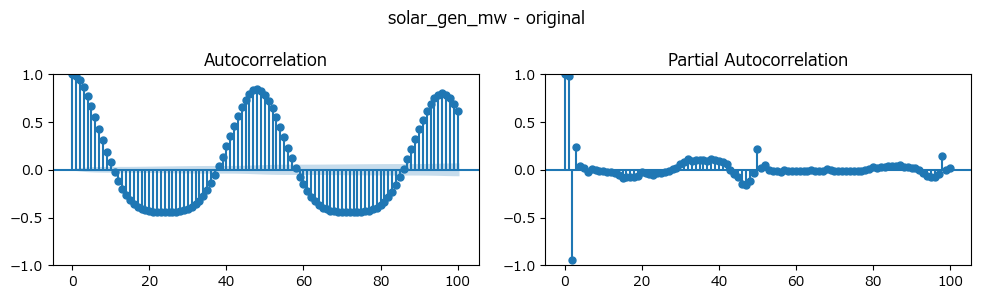

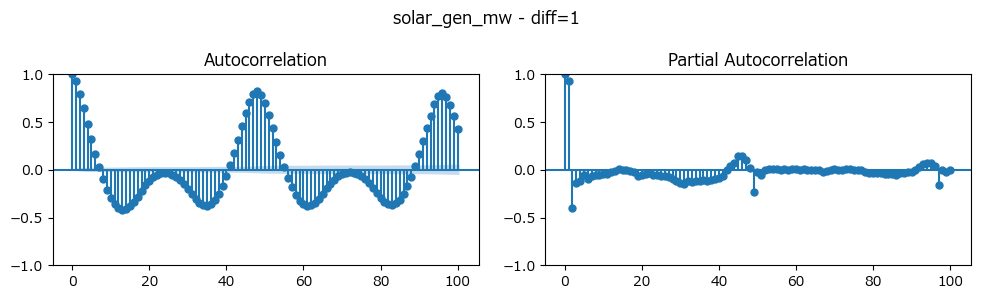

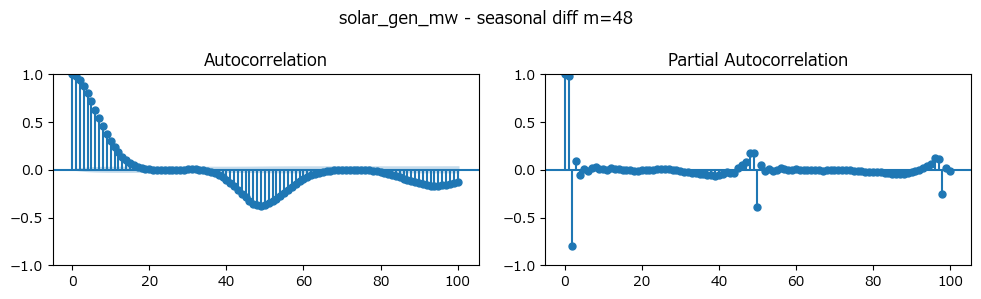

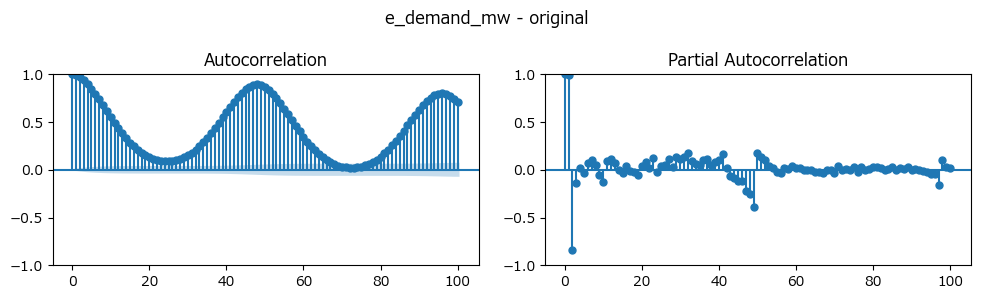

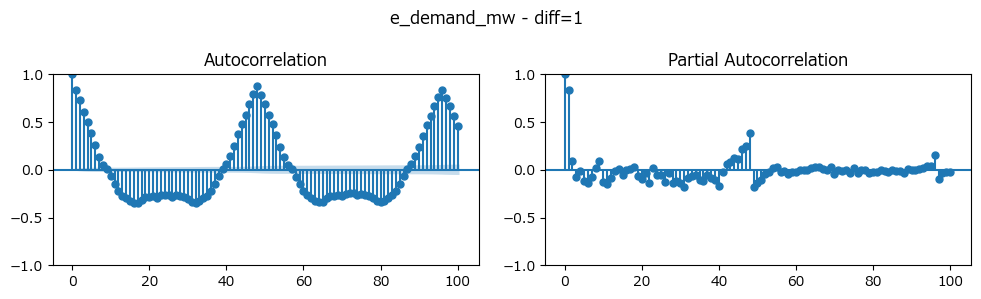

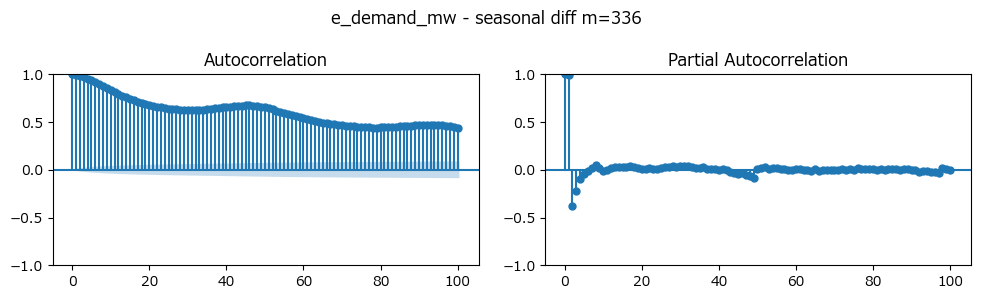


=== Diagnosis Complete ===


In [10]:
# =====================================================
# ACF/PACF Visualization
# =====================================================

def plot_acf_pacf(series, title):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    plot_acf(series.dropna(), lags=100, ax=ax[0])
    plot_pacf(series.dropna(), lags=100, ax=ax[1])
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

for col, m in [('solar_gen_mw', 48), ('e_demand_mw', 336)]:
    series = df[col]
    plot_acf_pacf(series, f"{col} - original")
    plot_acf_pacf(series.diff().dropna(), f"{col} - diff=1")
    plot_acf_pacf(series.diff(m).dropna(), f"{col} - seasonal diff m={m}")

print("\n=== Diagnosis Complete ===")

**(Graph Image: Power Generation)**
![](../fig/fig01_05.png)
![](../fig/fig01_06.png)
![](../fig/fig01_07.png)

**(Graphs: Demand)**
![](../fig/fig01_08.png)
![](../fig/fig01_09.png)
![](../fig/fig01_10.png)

#### 1-4-2. Examination of Graph-based Model Structure

* The following assumes analysis using ARIMA and SARIMA.

Generation
| Chart Title | Comments (ARIMA/SARIMA Hints) |
|------------|----------------------------------|
| **solar_gen_mw - original** | ACF is periodic and does not decay, and PACF is significant at many lags → Non-stationarity exists → **Differencing (d=1) is necessary**. Strong periodicity also suggests seasonality. |
| **solar_gen_mw - diff=1** | ACF continues periodically, but PACF is prominent at lags 1-3 → Candidates for AR(1-3) → **ARIMA(p=1-3, d=1)**. If periodicity remains, consider SARIMA. |
| **solar_gen_mw - seasonal diff m=48** | Prominent spikes in PACF at lag 1 and lag 48 → Candidates for **SARIMA(p=1, P=1, s=48)**. ACF also shows periodicity. Seasonality of 48 (1 day) is appropriate. |

Consumption
| Chart Title | Comments (ARIMA/SARIMA Hints) |
|------------|----------------------------------|
| **e_demand_mw - original** | ACF is periodic and PACF is significant at many lags → Non-stationarity → **Differencing (d=1) is necessary**. Periodicity is likely weekly. |
| **e_demand_mw - diff=1** | ACF is periodic, PACF is prominent at lags 1-2 → Candidates for AR(1-2) → **ARIMA(p=1-2, d=1)**. If periodicity remains, consider SARIMA. |
| **e_demand_mw - seasonal diff m=336** | PACF is prominent at lag 1 and lag 336 → Candidates for **SARIMA(p=1, P=1, s=336)**. ACF also shows periodicity. Seasonality of 336 (7 days) is appropriate. |

Observation Results and Derived Judgments

Based on a comprehensive judgment of stationarity test results and the shapes of ACF/PACF graphs, the following model parameters are used as a starting point for consideration.

* Ordinary Differencing (d): Stationarity was confirmed for both ADF/KPSS in the series where 1st order differencing (diff=1) was applied, and since the ACF showed a rapid decay or a sinusoidal change, it is considered that ordinary differencing $d=1$ is appropriate.

* Seasonal Differencing (D): Despite the OCSB test result of $D=0$, strong periodicity remains in the ACF/PACF of the original series and the 1st order differenced series (especially for generation $m=48$). This suggests that, regardless of the OCSB result, it is worthwhile to attempt seasonal differencing $D=1$ to improve model fit. In this case, the seasonal period $S$ for the SARIMA model can be assumed as $S=48$ (1 day) for generation and $S=336$ (1 week) for consumption.
* Non-seasonal Orders (p, q): From the PACF after $d=1$, generation $p$ is determined to be a candidate of 1-3, and consumption $p$ is 1-2.

**Key Findings**

1.  For both solar power generation and electricity demand (=consumption), when differencing was not applied, ADF indicated stationarity while KPSS indicated non-stationarity, which was inconsistent. However, applying first-order differencing or seasonal differencing (generation: S=48 (1 day), consumption: S=336 (1 week)) resulted in stationarity for both tests.

2.  Regarding seasonal differencing, the OCSB test indicated that for both generation (S=48) and consumption (S=336), D=0 was sufficient.

3.  Observation of the ACF and PACF plots revealed:
    For generation, the original series showed strong periodicity at 48 lags, and seasonal differencing with period 48 seemed to slightly mitigate this periodicity. Although this contradicts point 2, S=48 has high certainty, and considering PACF as well, there is a high probability of 0<=p<=3, d=1.
    For consumption, the original series also showed strong periodicity at 48 lags. Considering PACF, there is a high probability of 0<=p<=2, d=1. Furthermore, given that differencing with period 336 significantly smoothed the periodicity in the ACF, there is a high probability of S=336, D=1.